# Authors: Wenbo Fu (679744457), Bingyan Liu(668046518)

# Part I: Implement Lasso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Data

In [2]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [3]:
X.shape, len(y)

((506, 13), 506)

CD for Lasso

In [4]:
def one_var_lasso(r, x, lam):
    n = len(x)
    a = sum(r*x)/sum(x*x)
    eta = 2*n*lam/sum(x*x)
    if a > eta/2:
        return a-eta/2
    if abs(a) <= eta/2:
        return 0
    return a+eta/2

In [5]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 

    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    newX = (X - X_mean) / X_std

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    y_mean = np.mean(y)
    r = y

    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    # Scale back the coefficients;
    # Update the intercepts stored in B[0,]
    B[1:,:] = B[1:,:] / X_std.reshape(-1,1)
    B[0,:] = y_mean-np.sum(B[1:,:] * X_mean.reshape(-1,1),axis = 0)
    
    
    return(B)

In [6]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.3099945835128403, 0.49974219884804044)

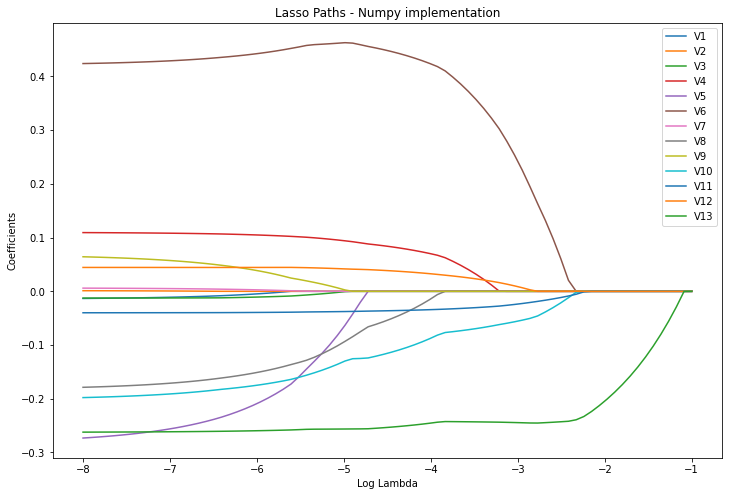

In [7]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

Check the accuracy

In [8]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [9]:
abs(myout - lasso_coef).max()

0.004645317415969075

# Part II: Simulation Study

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
import warnings
warnings.filterwarnings('ignore')

## Case I

Load Data

In [12]:
myData = pd.read_csv('Coding2_Data2.csv')
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [13]:
X.shape, len(Y)

((506, 91), 506)

In [14]:
def full_err(X_train, Y_train, X_test, Y_test):
    full = lm().fit(X_train, Y_train)
    return mean_squared_error(Y_test, full.predict(X_test))

In [15]:
def ridge_err(X_train, Y_train, X_test, Y_test):
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                      scoring = 'neg_mean_squared_error', 
                      normalize = True)
    ridgecv.fit(X_train, Y_train)
    ridge_model = Ridge(alpha = ridgecv.alpha_, normalize = True)
    ridge_model.fit(X_train, Y_train)
    return mean_squared_error(Y_test, ridge_model.predict(X_test))

In [16]:
def lasso_err(X_train, Y_train, X_test, Y_test):
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10, 
                  normalize = True)
    lassocv.fit(X_train, Y_train)
    
    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 

    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)

    alpha_min = cv_alphas[min_idx]

    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    lasso_model_min = Lasso(alpha = alpha_min, normalize = True, max_iter=10000)
    lasso_model_min.fit(X_train, Y_train)
    lasso_min = mean_squared_error(Y_test, lasso_model_min.predict(X_test))
    
    lasso_model_1se = Lasso(alpha = alpha_1se, normalize = True, max_iter=10000)
    lasso_model_1se.fit(X_train, Y_train)
    lasso_1se = mean_squared_error(Y_test, lasso_model_1se.predict(X_test))
    
    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
    lasso_refit = mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices]))
    return lasso_min, lasso_1se, lasso_refit

In [17]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [18]:
def pcr_err(X_train, Y_train, X_test, Y_test):
    pcr_model = PCR()
    pcr_model.fit(X_train.to_numpy(), Y_train.to_numpy())
    return mean_squared_error(Y_test, pcr_model.predict(X_test.to_numpy()))   

In [22]:
np.random.seed(4457)

maxit = 50

full = []
ridge = []
lasso_min = []
lasso_1se = []
lasso_refit = []
pcr = []
n = len(Y)

start_time = time.time()
for it in range(maxit):
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]

    # Splitting the data into training and testing sets
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]
    
    full.append(full_err(X_train, Y_train, X_test, Y_test))
    ridge.append(ridge_err(X_train, Y_train, X_test, Y_test))
    lasso_min_error, lasso_1se_error, lasso_refit_error = lasso_err(X_train, Y_train, X_test, Y_test)
    lasso_min.append(lasso_min_error)
    lasso_1se.append(lasso_1se_error)
    lasso_refit.append(lasso_refit_error)
    pcr.append(pcr_err(X_train, Y_train, X_test, Y_test))
    
    end_time = time.time()
    
    if it%5 == 0:
        print(f"finish evluation iteration {it} -------")
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:f} seconds")

finish evluation iteration 0 -------
Elapsed time: 5.667754 seconds
finish evluation iteration 5 -------
Elapsed time: 31.226666 seconds
finish evluation iteration 10 -------
Elapsed time: 55.940795 seconds
finish evluation iteration 15 -------
Elapsed time: 83.381803 seconds
finish evluation iteration 20 -------
Elapsed time: 112.661831 seconds
finish evluation iteration 25 -------
Elapsed time: 140.643781 seconds
finish evluation iteration 30 -------
Elapsed time: 169.323101 seconds
finish evluation iteration 35 -------
Elapsed time: 196.991015 seconds
finish evluation iteration 40 -------
Elapsed time: 224.979786 seconds
finish evluation iteration 45 -------
Elapsed time: 252.908528 seconds


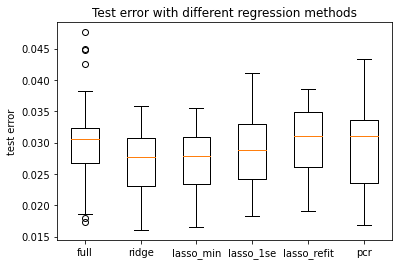

In [23]:
plt.boxplot([full, ridge, lasso_min,lasso_1se,lasso_refit,pcr])
plt.xticks([1, 2, 3, 4, 5, 6], ['full', 'ridge', 'lasso_min', 'lasso_1se','lasso_refit','pcr'])
plt.ylabel('test error')
plt.title('Test error with different regression methods')
plt.show()

Discussion:

1. Ridge and Lasso_min yield best performances
2. Full and Lasso_refit yied worst performances
3. Lasso_min yield a better performance than Lasso_1se
4. Refit decrease error variance but increase error mean, does not improve performance
5. Neither is significantly better than others, selection can reduce model variance but does not imporve accuracy much

## Case II

load data

In [24]:
myData = pd.read_csv('Coding2_Data3.csv')
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [25]:
X.shape, len(Y)

((506, 591), 506)

In [26]:
np.random.seed(4457)
maxit = 50

ridge2 = []
lasso_min2 = []
lasso_1se2 = []
lasso_refit2 = []
pcr2 = []
n = len(Y)

start_time = time.time()
for it in range(maxit):
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]

    # Splitting the data into training and testing sets
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]
    
    ridge2.append(ridge_err(X_train, Y_train, X_test, Y_test))
    lasso_min_error, lasso_1se_error, lasso_refit_error = lasso_err(X_train, Y_train, X_test, Y_test)
    lasso_min2.append(lasso_min_error)
    lasso_1se2.append(lasso_1se_error)
    lasso_refit2.append(lasso_refit_error)
    pcr2.append(pcr_err(X_train, Y_train, X_test, Y_test))
    
    end_time = time.time()
    
    if it%5 == 0:
        print(f"finish evluation iteration {it} -------")
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:f} seconds")

finish evluation iteration 0 -------
Elapsed time: 37.874061 seconds
finish evluation iteration 5 -------
Elapsed time: 249.452571 seconds
finish evluation iteration 10 -------
Elapsed time: 661.837844 seconds
finish evluation iteration 15 -------
Elapsed time: 2961.277020 seconds
finish evluation iteration 20 -------
Elapsed time: 3495.574246 seconds
finish evluation iteration 25 -------
Elapsed time: 3694.171731 seconds
finish evluation iteration 30 -------
Elapsed time: 4397.465461 seconds
finish evluation iteration 35 -------
Elapsed time: 4954.802401 seconds
finish evluation iteration 40 -------
Elapsed time: 5161.943203 seconds
finish evluation iteration 45 -------
Elapsed time: 5382.277954 seconds


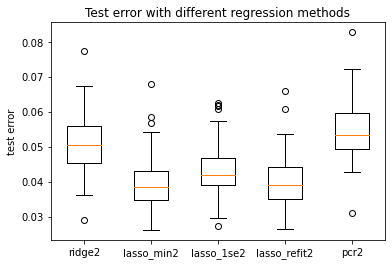

In [28]:
plt.boxplot([ridge2, lasso_min2,lasso_1se2,lasso_refit2,pcr2])
plt.xticks([1, 2, 3, 4, 5], ['ridge2', 'lasso_min2', 'lasso_1se2','lasso_refit2','pcr2'])
plt.ylabel('test error')
plt.title('Test error with different regression methods')
plt.show()

In [48]:
from matplotlib.ticker import MultipleLocator
tick_spacing = 1
locator = MultipleLocator(base=tick_spacing)

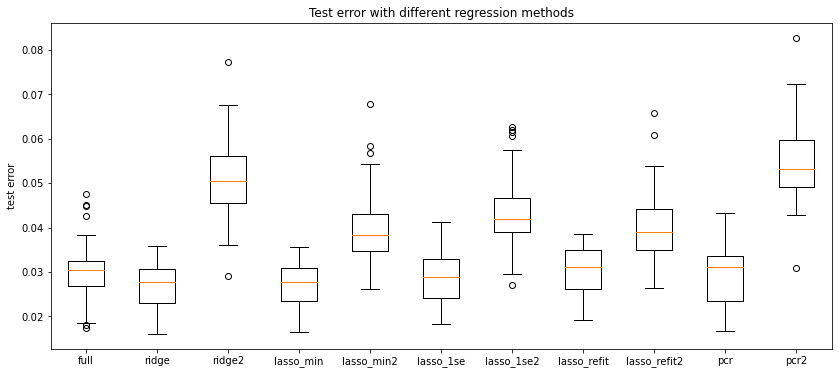

In [66]:
plt.figure(figsize=(14, 6)) 
plt.boxplot([full, ridge, ridge2, lasso_min,lasso_min2,lasso_1se,lasso_1se2,lasso_refit,lasso_refit2,pcr,pcr2])
plt.xticks(list(range(1,12)), ['full','ridge','ridge2', 'lasso_min','lasso_min2','lasso_1se', 'lasso_1se2','lasso_refit','lasso_refit2','pcr','pcr2'])
plt.ylabel('test error')
plt.title('Test error with different regression methods')
plt.show()

Discussion:

1. Lasso_min2 and Lasso_refit2 yield best performances
2. Ridge and PCR yield worst performances
3. Ridge and PCR perform worse in case II, ridge will only soft the contribution(d/(d^2+lambda)) from each PCR components and the newly introduced random features all have some fixed variance and will still contribute, but these features will give more variances in the MSPE; similar for PCR as it will also include contributions from these random features if the variance is significant.
4. No, the performances are worse as more features will give more test errors if those do not reduce bias